Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import asc, desc, log
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.sql.types import IntegerType, StringType, DoubleType, LongType, BooleanType, TimestampType, DateType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, MinMaxScaler, StringIndexer,OneHotEncoderEstimator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVCModel, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline, PipelineModel
import time
import pandas as pd
from workspace_utils import active_session
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify_Modelling") \
    .getOrCreate()

# Reading Data

In [4]:
data_path = "final_df.json"

In [5]:
df = spark.read.json(data_path)

In [6]:
df=df.dropDuplicates()

In [7]:
df.groupBy("user_churn_flag").count().show()

+---------------+------+
|user_churn_flag| count|
+---------------+------+
|              0|233290|
|              1| 44864|
+---------------+------+



We have too many values for class 0. In this way, we need to apply undersampling technique to get a model capable to predict both class in a fair way

https://github.com/phatak-dev/spark-ml-kaggle/blob/master/src/main/scala/com/madhukaraphatak/spark/ml/UnderSampling.scala

In [8]:
def undersample(df):
    '''
    Undersampling values for minority class no churn (0)
    Input : Spark dataframe
    Output: Balanced Spark Dataframe
    '''
    FraudDf = df.filter(df.user_churn_flag=='1')
    nonFraudDf = df.filter(df.user_churn_flag=='0')
    #random sample the nonFraud to match the value of fraud
    sampleRatio = df.filter(df.user_churn_flag=='1').count()
    nonFraudSampleDf = nonFraudDf.sample(1.0,seed=42).limit(sampleRatio)
    result = FraudDf.union(nonFraudSampleDf)
    
    return result

In [9]:
result = undersample(df)

In [10]:
result.groupBy("user_churn_flag").count().show()

+---------------+-----+
|user_churn_flag|count|
+---------------+-----+
|              0|44864|
|              1|44864|
+---------------+-----+



In [11]:
result.printSchema()

root
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- active_days_count: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- current_condition: string (nullable = true)
 |-- downgraded: long (nullable = true)
 |-- firstName: string (nullable = true)
 |-- 

In [12]:
df= result.select('About','Add Friend','Add to Playlist','Downgrade','Error','Help','Home','Logout','NextSong','Roll Advert',
   'Save Settings','Settings','Submit Downgrade','Submit Upgrade','Thumbs Down','Thumbs Up','Upgrade','active_days_count',
    'gender_flag','tenure','status','level','location_state','os','browser','current_condition','user_churn_flag')

In [13]:
df.columns[:-6]

['About',
 'Add Friend',
 'Add to Playlist',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Save Settings',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade',
 'active_days_count',
 'gender_flag',
 'tenure',
 'status']

In [14]:
# One hot enconding and vector assembler
status_indexer = StringIndexer(inputCol='status', outputCol='status_index')
level_indexer = StringIndexer(inputCol='current_condition', outputCol='level_index')
loc_st_indexer = StringIndexer(inputCol='location_state', outputCol='loc_st_index')
os_indexer = StringIndexer(inputCol='os', outputCol='os_index')
browser_indexer = StringIndexer(inputCol='browser', outputCol='browser_index')

ohe = OneHotEncoderEstimator(inputCols=['status_index','level_index','os_index','loc_st_index',
                                 'browser_index'],outputCols=['status_enc','level_enc','os_enc','loc_st_enc','browser_enc'])
assembler = VectorAssembler(inputCols=df.columns[:-6]+['status_enc','level_enc','os_enc','loc_st_enc','browser_enc']
                            , outputCol="FeatureVec")
minMax = MinMaxScaler(inputCol = assembler.getOutputCol(), outputCol="features")



# Split data and prepare to Predict

In [15]:
# fit pipeline
pipeline = Pipeline(stages=[status_indexer, level_indexer,loc_st_indexer, os_indexer, browser_indexer, ohe, assembler,minMax])
start = time.time()
pipelineModel = pipeline.fit(df)
end = time.time()
total = end -start
print(f"total time to fit: {total}")

total time to fit: 165.885577917099


In [16]:
# transform Pipeline
model_prep = pipelineModel.transform(df)


In [17]:
features = [col for col in model_prep.columns if col!='user_churn_flag']

In [18]:
data = model_prep.select("features","user_churn_flag")

In [19]:
splits = data.randomSplit([0.7, 0.3],seed=42)
train = splits[0].withColumnRenamed("user_churn_flag", "target")
test = splits[1].withColumnRenamed("user_churn_flag", "target")
train_rows = train.count()
test_rows = test.count()
print("Training Rows:", train_rows, " Testing Rows:", test_rows)

Training Rows: 62881  Testing Rows: 26847


In [20]:
train.select('target').agg(F.avg('target')).show()

+-------------------+
|        avg(target)|
+-------------------+
|0.49830632464496427|
+-------------------+



In [21]:
test.select('target').agg(F.avg('target')).show()

+------------------+
|       avg(target)|
+------------------+
|0.5039669236786233|
+------------------+



# Random Forest

In [22]:
rf = RandomForestClassifier(labelCol='target',seed=42)
start = time.time()
model_rf = rf.fit(train)
end = time.time()
total = end -start
print(f"total time to fit: {total}")

total time to fit: 111.12432837486267


In [108]:
prediction = model_rf.transform(test)
predicted = prediction.select("features", "prediction", "target")

predicted.show(2)

+--------------------+----------+------+
|            features|prediction|target|
+--------------------+----------+------+
|[0.0,0.0,0.0125,0...|       1.0|     1|
|[0.0,0.0,0.0125,0...|       1.0|     1|
+--------------------+----------+------+
only showing top 2 rows



In [109]:
tp = float(predicted.filter("prediction == 1.0 AND target == 1").count())
fp = float(predicted.filter("prediction == 1.0 AND target == 0").count())
tn = float(predicted.filter("prediction == 0.0 AND target == 0").count())
fn = float(predicted.filter("prediction == 0.0 AND target == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|           13530.0|
|       FP|            3471.0|
|       TN|            9846.0|
|       FN|               0.0|
|Precision|0.7958355390859361|
|   Recall|               1.0|
|       F1|0.8863122727719366|
+---------+------------------+



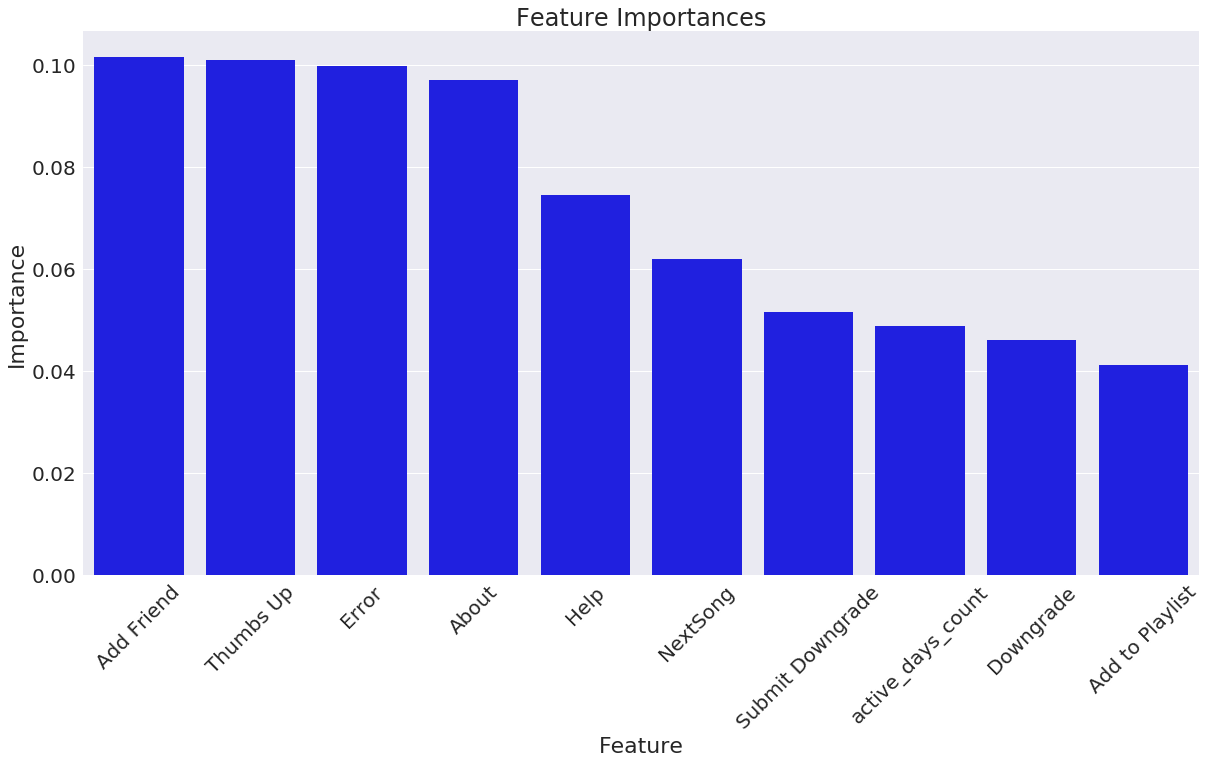

In [49]:
feat_importance = pd.DataFrame(list(zip(features,model_rf.featureImportances)), 
                               columns= ["Feature","Importance"])

plt.figure(figsize = (20,10))
sns.set(font_scale = 2)
plt.title("Feature Importances")
sns.barplot(x="Feature", y="Importance", data=feat_importance.sort_values(by="Importance", ascending=False).head(10), color="blue")
plt.xticks(rotation=45);

# Logistic Regression

In [114]:
lr = LogisticRegression(labelCol='target')



In [116]:
start = time.time()
lr_model = lr.fit(train)
end = time.time()
total = end -start

print(f"total time to fit: {total}")

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'LogisticRegression' object has no attribute '_java_obj'


total time to fit: 324.1105167865753


In [117]:
prediction = lr_model.transform(test)
predicted = prediction.select("features", "prediction", "target")

predicted.show(2)

+--------------------+----------+------+
|            features|prediction|target|
+--------------------+----------+------+
|[0.0,0.0,0.0125,0...|       1.0|     1|
|[0.0,0.0,0.0125,0...|       0.0|     1|
+--------------------+----------+------+
only showing top 2 rows



In [118]:
tp = float(predicted.filter("prediction == 1.0 AND target == 1").count())
fp = float(predicted.filter("prediction == 1.0 AND target == 0").count())
tn = float(predicted.filter("prediction == 0.0 AND target == 0").count())
fn = float(predicted.filter("prediction == 0.0 AND target == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|           13394.0|
|       FP|             665.0|
|       TN|           12652.0|
|       FN|             136.0|
|Precision|0.9526993385020271|
|   Recall|0.9899482631189949|
|       F1|0.9709666896226757|
+---------+------------------+



# Gbt Classifier

In [119]:
gbt = GBTClassifier(labelCol='target',seed=42)

In [120]:

start = time.time()
gbt_model = gbt.fit(train)
end = time.time()
total = end -start

In [121]:
print(f"total time to fit: {total}")

total time to fit: 455.3363652229309


In [123]:
prediction = gbt_model.transform(test)
predicted = prediction.select("features", "prediction", "target")

predicted.show(2)

+--------------------+----------+------+
|            features|prediction|target|
+--------------------+----------+------+
|[0.0,0.0,0.0125,0...|       1.0|     1|
|[0.0,0.0,0.0125,0...|       1.0|     1|
+--------------------+----------+------+
only showing top 2 rows



In [124]:
tp = float(predicted.filter("prediction == 1.0 AND target == 1").count())
fp = float(predicted.filter("prediction == 1.0 AND target == 0").count())
tn = float(predicted.filter("prediction == 0.0 AND target == 0").count())
fn = float(predicted.filter("prediction == 0.0 AND target == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|           13527.0|
|       FP|             258.0|
|       TN|           13059.0|
|       FN|               3.0|
|Precision|0.9812840043525571|
|   Recall|0.9997782705099778|
|       F1|0.9904448105436573|
+---------+------------------+



 Random Forest was the model with the best perfomance and without overfittung

# Model Selection - Cross Validation Random Forest

In [55]:

paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [20, 30])
             .addGrid(rf.maxDepth, [5, 8])
             .build())


evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', metricName='f1')
evaluator.setLabelCol('target')
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=4)
with active_session():
    start = time.time()
    cvModel = cv.fit(train)
    end = time.time()
    total = end -start
    print(f"total time to fit: {total}")
    predictions = cvModel.transform(test)


total time to fit: 1232.2062797546387


In [56]:
cvModel.bestModel

RandomForestClassificationModel (uid=RandomForestClassifier_54dbcb6f7fea) with 30 trees

In [57]:
predictions

DataFrame[features: vector, target: bigint, rawPrediction: vector, probability: vector, prediction: double]

In [58]:
#get the best model
best_model = cvModel.bestModel


In [59]:
results = best_model.transform(test)


In [60]:
# what are the best parameters
print('Best parameters for Random Fores CV : max depth:{}, num Trees:{}'.\
          format(best_model.getOrDefault('maxDepth'), best_model.getNumTrees))

Best parameters for Random Fores CV : max depth:8, num Trees:30


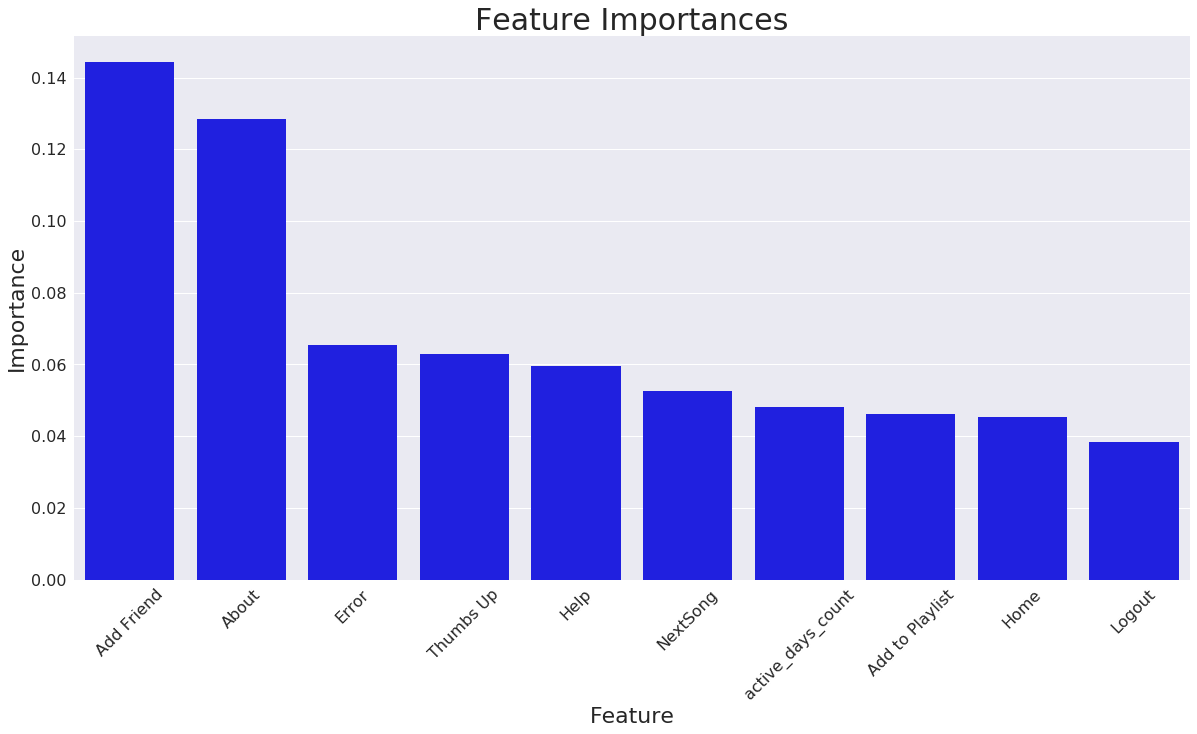

In [61]:
feat_importance = pd.DataFrame(list(zip(features,cvModel.bestModel.featureImportances)), 
                               columns= ["Feature","Importance"])

plt.figure(figsize = (20,10))
sns.set(font_scale = 2)

plt.title("Feature Importances",fontsize=30)
sns.barplot(x="Feature", y="Importance", data=feat_importance.sort_values(by="Importance", ascending=False).head(10), color="blue")
plt.xticks(rotation=45,fontsize=16);
plt.yticks(fontsize=16);

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [66]:
metrics = ["weightedRecall","weightedPrecision", "f1" ]
metrics_test = []
    
for metric in metrics: 
    metric_final = evaluator.evaluate(predictions.select('target','prediction'),{evaluator.metricName: metric})
    metrics_test.append(metric_final)

In [67]:
metrics_test

[0.9311654933512123, 0.9394374512317534, 0.9307995939731124]

In [64]:
results

DataFrame[features: vector, target: bigint, rawPrediction: vector, probability: vector, prediction: double]

In [65]:
evaluator

MulticlassClassificationEvaluator_dfabb040de33

In [54]:
metric_final

0.9625393700667393